# Rotation rates for the main sites during MOSAiC

In [6]:
# Import data from ASFS and MetCity 
import xarray as xr
import pandas as pd
import numpy as np
import os

# Downloaded ADC data (cox et al. 2023)
dataloc = '/Users/dwatkin2/Documents/research/data/mosaic_met_data/'
saveloc = '../data/met_data/'
startdate = 20200515
enddate = 20200731
for source in ['metcity', 'asfs40', 'asfs50', 'asfs30']:
    print(source)
    files = os.listdir(dataloc + source + '/data/')    
    files = [f for f in files if '10min' in f]
    files = [f for f in files if (int(f.split('.')[-3]) > startdate) & (int(f.split('.')[-3]) < enddate)]
    files.sort()

    dfs = []
    for file in files:
        with xr.open_dataset(dataloc + source + '/data/' + file) as ds:
            if source == 'metcity':
                variables = ['lat_tower', 'lon_tower', 'tower_heading', 'atmos_pressure_2m',
                             'temp_2m', 'temp_6m', 'temp_10m',
                             'rh_2m', 'rh_6m', 'rh_10m',
                             'wspd_u_mean_2m', 'wspd_u_mean_6m', 'wspd_u_mean_10m',
                             'wspd_v_mean_2m', 'wspd_v_mean_6m', 'wspd_v_mean_10m']                
            else:
                variables = ['lat', 'lon', 'heading', 'atmos_pressure',
                             'temp', 'rh', 'wspd_u_mean', 'wspd_v_mean']
            if variables[0] + '_qc' in ds.variables:
                df = ds[variables + [v + '_qc' for v in variables]].to_dataframe()
                for v in variables:
                    df.loc[df[v + '_qc'] != 0, v] = np.nan
            else:                
                df = ds[variables].to_dataframe()
            if source == 'metcity':
                df.rename({'lat_tower': 'latitude', 'lon_tower': 'longitude'}, axis=1, inplace=True)
            else:
                df.rename({'lat': 'latitude', 'lon': 'longitude'}, axis=1, inplace=True)
            dfs.append(df.loc[:, [v for v in df.columns if v[-2:] != 'qc']])
    df_all = pd.concat(dfs)
    df_all = df_all.sort_index()
    df_all.to_csv('../../data/met_data/' + source + '.csv')

metcity
asfs40


ValueError: No objects to concatenate

# 

In [9]:
dfs

[]

In [43]:
df = pd.read_csv('../../data/met_data/metcity.csv', parse_dates=['time'])
df.set_index('time', inplace=True)

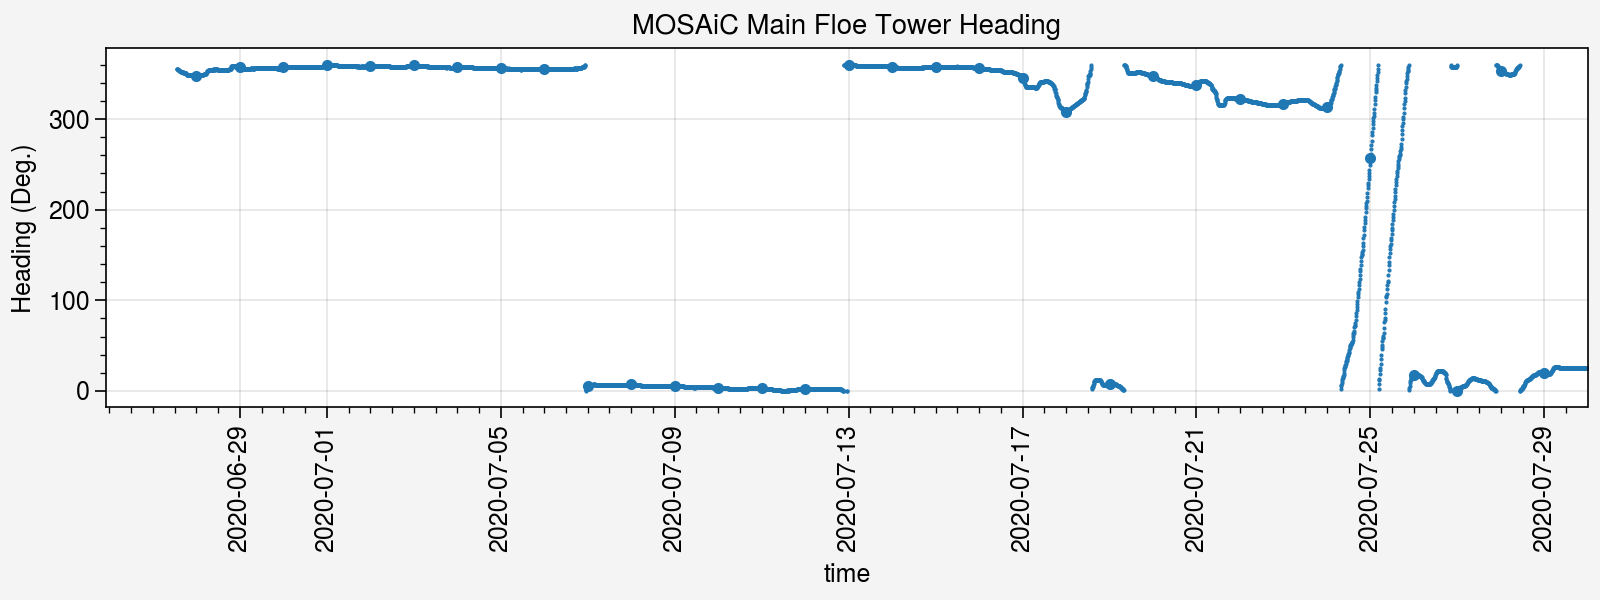

In [158]:
import proplot as pplt
fig, ax = pplt.subplots(width=8, height=3)
ax.plot(df.tower_heading.interpolate(), lw=0, m='.', ms=1, color='tab:blue')
ax.plot(df.tower_heading.interpolate().resample('1d').asfreq(), lw=0, m='.', color='tab:blue')

ax.format(ylabel=('Heading (Deg.)'), title='MOSAiC Main Floe Tower Heading')
fig.save('../figures/figS5_mosaic_heading.png', dpi=300)

In [144]:
# Convert to cumulative orientation
test_rad = np.deg2rad(df.tower_heading.interpolate()) / np.pi
# init = test_rad.copy()
test_diff = np.diff(test_rad)
for idx in range(0, len(test_rad)-1):
    if test_diff[idx] < -1.5:
        test_rad.iloc[idx+1:] += 2
        print(test_diff[idx], test_rad.index[idx])
    elif test_diff[idx] > 1.5:
        test_rad.iloc[idx+1:] -= 2
        print(test_diff[idx], test_rad.index[idx])
        # test_diff = np.diff(test_rad)
        

-1.9972047407246571 2020-07-06 22:40:00
1.9989512870613453 2020-07-12 21:10:00
-1.9995748252396401 2020-07-12 22:40:00
1.9994064254409434 2020-07-12 23:00:00
-1.9846790445493019 2020-07-18 14:00:00
1.996973870682068 2020-07-19 07:50:00
-1.987331969014218 2020-07-24 07:30:00
-1.9858580936284778 2020-07-25 04:20:00
-1.991329631016927 2020-07-25 21:10:00
1.9948542227597459 2020-07-26 20:10:00
-1.9949765743596486 2020-07-26 23:50:00
1.9990213319543588 2020-07-27 21:10:00
-1.9974584445654644 2020-07-28 10:20:00


In [159]:
test_rad.head()

time
2020-06-07 00:00:00   NaN
2020-06-07 00:10:00   NaN
2020-06-07 00:20:00   NaN
2020-06-07 00:30:00   NaN
2020-06-07 00:40:00   NaN
Name: tower_heading, dtype: float64

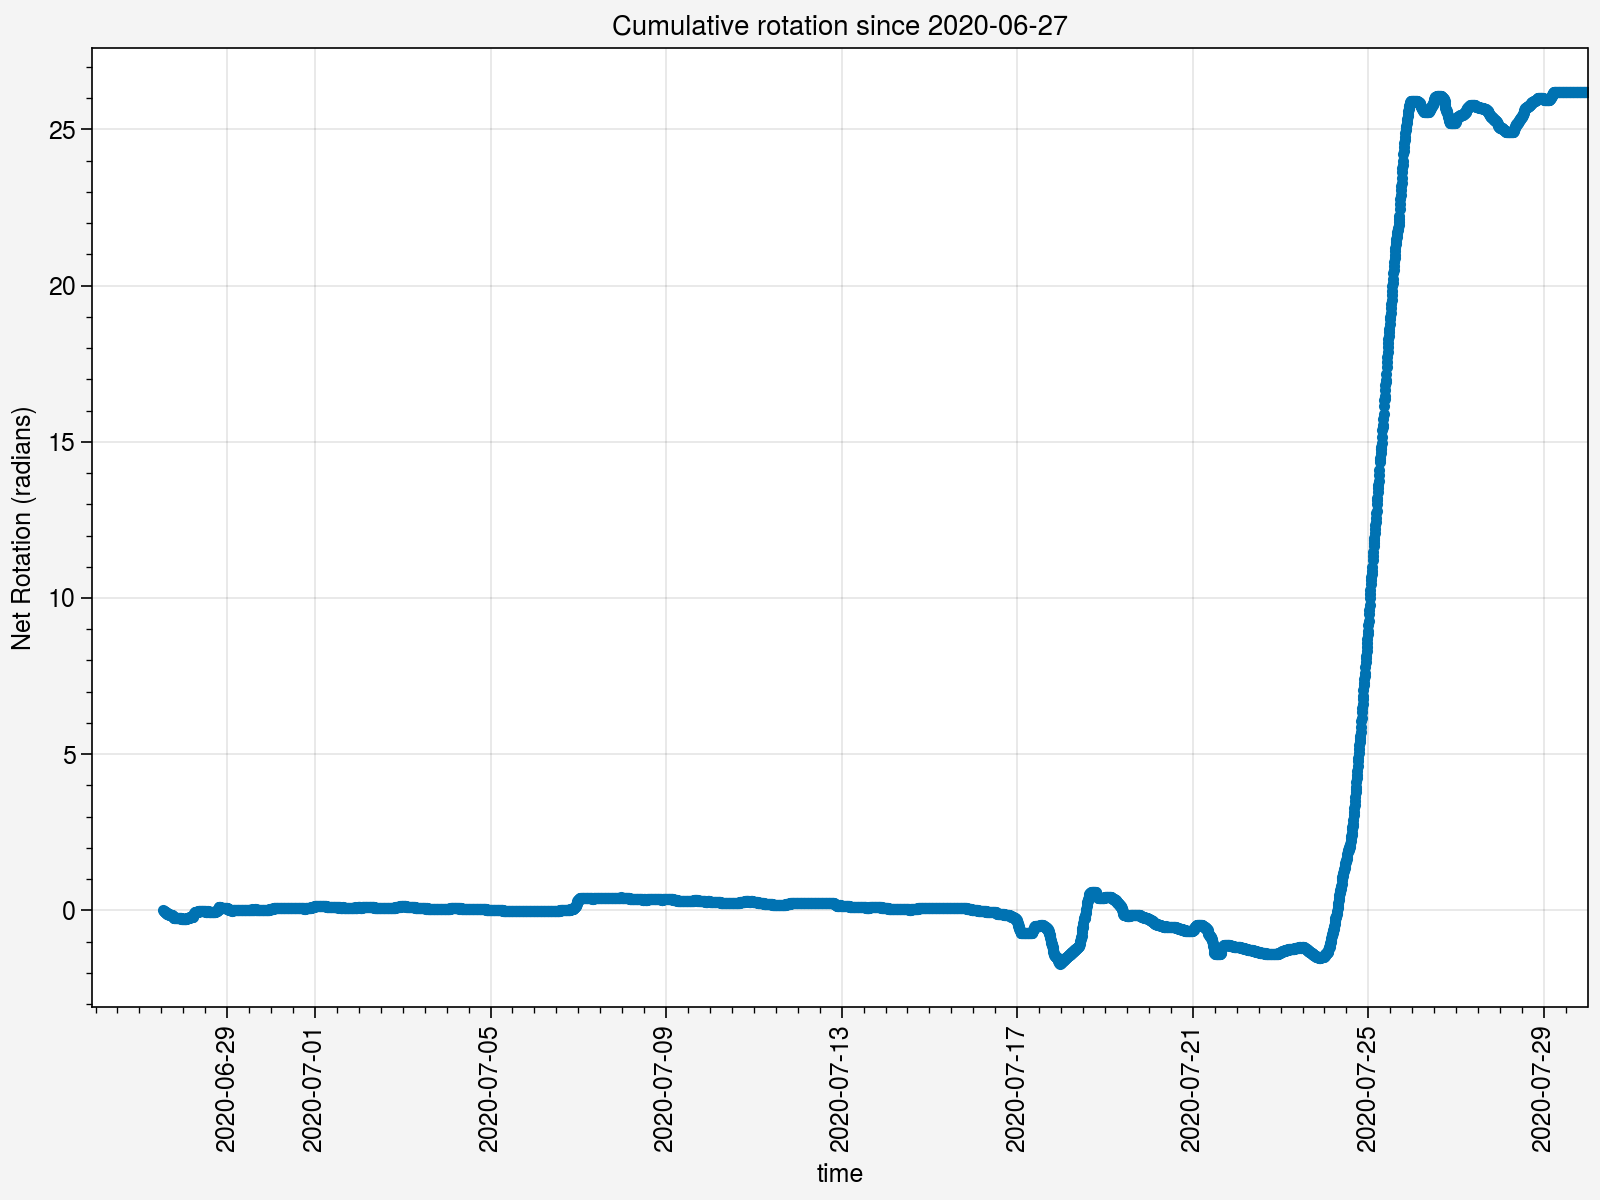

In [147]:
import proplot as pplt

fig, ax = pplt.subplots(width=8, height=6)
ax.plot(2*np.pi * (test_rad - test_rad.dropna().iloc[0]), marker='.')
ax.format(title='Cumulative rotation since ' + test_rad.dropna().index[0].strftime('%Y-%m-%d'),
         ylabel='Net Rotation (radians)')

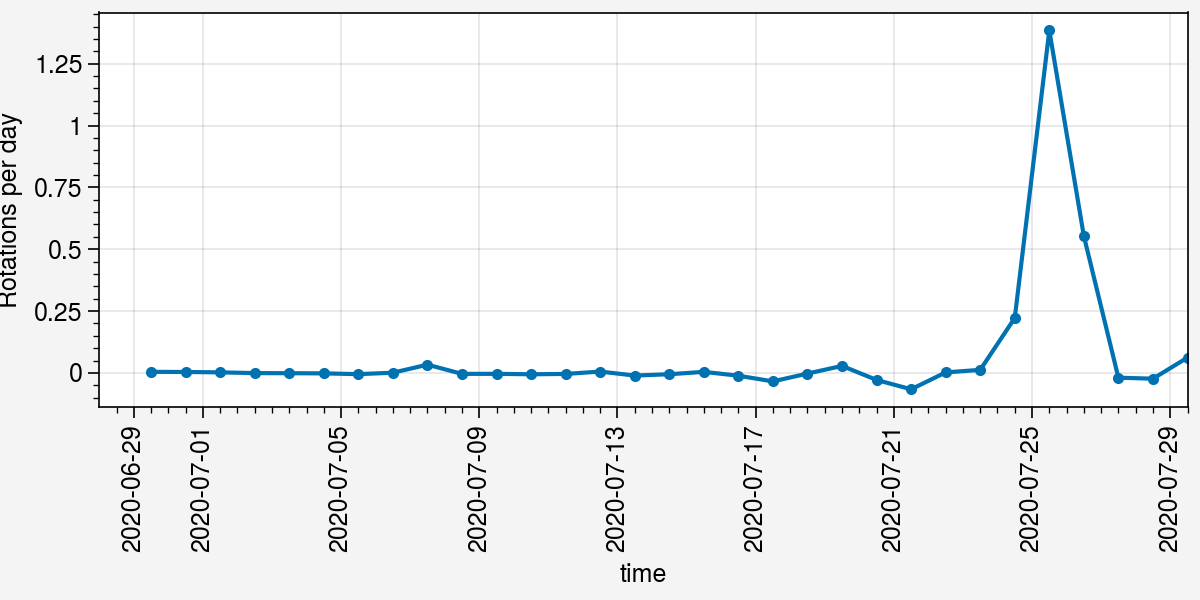

In [112]:
fig, ax = pplt.subplots(width=6, height=3)
idx = (test_rad.index.hour == 12) & (test_rad.index.minute == 0)
daily_change = (test_rad.loc[idx] - test_rad.loc[idx].shift(1))/2
ax.plot(daily_change, marker='.')
ax.format(ylabel='Rotations per day')

In [111]:
daily_change.loc[slice(pd.to_datetime('2020-07-24'), pd.to_datetime('2020-07-26'))]

time
2020-07-24 12:00:00    1.394554
2020-07-25 12:00:00    8.700121
Name: tower_heading, dtype: float64

In [136]:
# Convert from rotations to radians per day
daily_change = daily_change.dropna() * 2*np.pi

In [137]:
q5, q75, q95, q99 = daily_change[daily_change > 0].quantile([0.5, 0.75, 0.95, 0.99])

In [138]:
np.abs(daily_change[daily_change < 0]).quantile([0.5, 0.75, 0.95, 0.99])

0.50    0.034288
0.75    0.122427
0.95    0.256516
0.99    0.384670
Name: tower_heading, dtype: float64

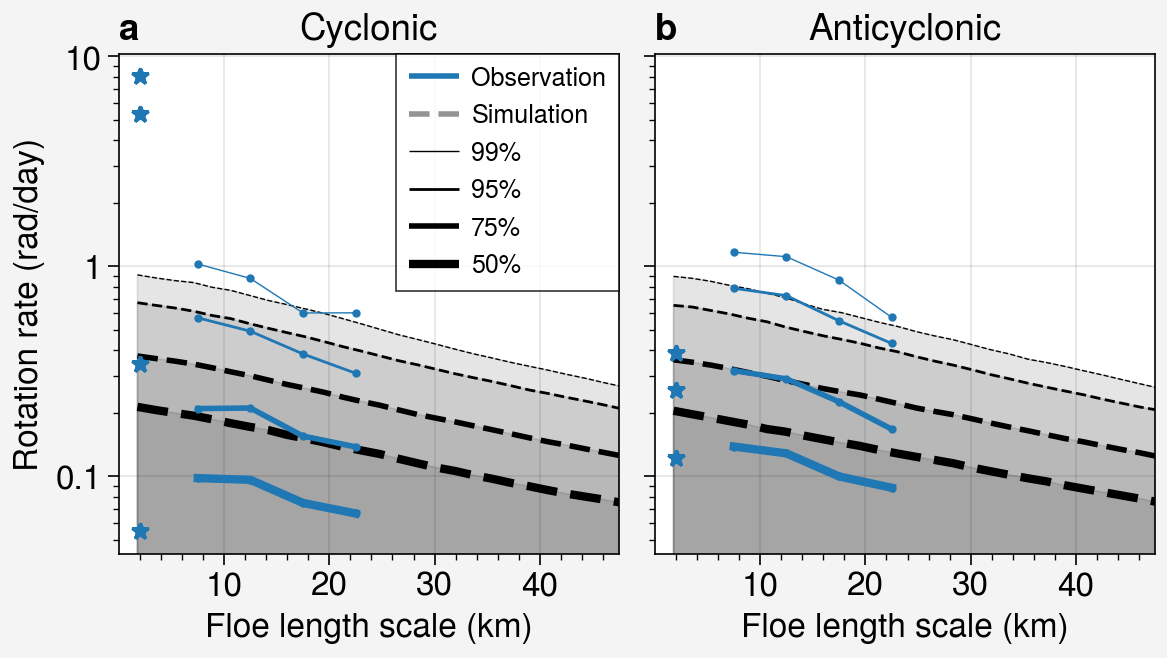

In [154]:
import itertools
import numpy as np
import pandas as pd
import proplot as pplt
import os
import pyproj
import sys
import warnings
import xarray as xr
# sys.path.append('/Users/dwatkin2/Documents/research/packages/buoy_processing/')
sys.path.append('../scripts/')
from scipy.interpolate import interp2d
from drifter import compute_velocity
from drifter import compute_along_across_components
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter('ignore')

#### Specify locations for data.
# External datasets not included in archive are stored in a lower 
# sic_loc = '../../../data/nsidc_daily_cdr/'
# motion_loc = '../../../data/nsidc_daily_icemotion/'
ift_loc = '../data/floe_tracker/ift_floe_trajectories.csv'
df_ift = pd.read_csv(ift_loc, index_col=0)
df_ift['datetime'] = pd.to_datetime(df_ift['datetime'].values)
df_ift['area_adj_km2'] = (np.sqrt(df_ift.area) + 8)**2*.25*.25 # 8 pixel shift and convert to km2

# edge_bins = np.arange(0, 800, 25)
# df_ift['edge_bin'] = np.digitize(df_ift.edge_dist_km, bins=edge_bins)


df_ift['L'] = df_ift['area_adj_km2']**0.5
sic = df_ift['nsidc_sic']
df_ift.loc[sic > 1, 'nsidc_sic'] = np.nan

# Additional filter
# I think I added this into the prep script
speed = np.sqrt(df_ift.loc[:, 'u']**2 + df_ift.loc[:, 'v']**2)
mean_u = df_ift.loc[:, 'u'].mean()
mean_v = df_ift.loc[:, 'v'].mean()

z = np.sqrt((df_ift.u - mean_u)**2 + (df_ift.v - mean_v)**2)/np.std(speed)
df_ift['qc_flag'] = 0
df_ift.loc[np.abs(z) > 6, 'qc_flag'] = 1
df_filtered = df_ift.loc[df_ift.qc_flag==0]

df_filtered['l_bin'] = np.digitize(df_filtered['L'], bins=np.arange(0, 60, 5))
df_filtered['l_center'] = [pd.Series(np.arange(2.5, 63, 5), index=np.arange(1, 14))[x] for x in df_filtered['l_bin']]
subset = df_filtered.loc[(df_filtered.qc_flag == 0) & df_filtered.zeta.notnull()]

df_cyc = subset.where(subset.zeta > 0).dropna().pivot_table(
    columns='l_center', values='zeta', index='floe_id')
df_anticyc = -subset.where(subset.zeta < 0).dropna().pivot_table(
    columns='l_center', values='zeta', index='floe_id')

idx_cyc = df_cyc.notnull().sum(axis=0) > 100
idx_anticyc = df_anticyc.notnull().sum(axis=0) > 100

df_cyc = df_cyc.loc[:, idx_cyc].copy()
df_anticyc = df_anticyc.loc[:, idx_anticyc].copy()

sim_rot = pd.read_csv('../data/simulation/rotation_rates.csv')
sim_rot.columns = [c.replace('km', '') for c in sim_rot.columns]
sr_melted = sim_rot.melt()
sr_melted['variable'] = sr_melted['variable'].astype(int)
sr_melted.columns = ['length_scale', 'rotation_rate']
sr_melted['L'] = np.sqrt(np.pi*(sr_melted['length_scale'])**2)

fig, axs = pplt.subplots(ncols=2, sharex=False)
R = sim_rot.where(sim_rot > 0).quantile(0.99, axis=0).interpolate().index.astype(int)
L = np.sqrt(np.pi)*R

for q, lw, m in zip([0.99, 0.95, 0.75, 0.5],
                        [0.5, 1, 2, 3],
                   ['', '', '', '']):
    

    axs[0].plot(L, sim_rot.where(sim_rot > 0).quantile(q, axis=0), #.interpolate(),
                color='k', lw=lw, ls='--', marker=m, zorder=1)
    axs[0].area(L, sim_rot.where(sim_rot > 0).quantile(q, axis=0), #.interpolate(),
               alpha=0.1, color='k', zorder=0)
    
    axs[0].plot(df_cyc.columns, df_cyc.quantile(q, axis=0), #.interpolate(),
                color='tab:blue', lw=lw, marker='.', ls='-', ms=4, zorder=2)

    q5, q75, q95, q99 = daily_change[daily_change > 0].quantile([0.5, 0.75, 0.95, 0.99])
    axs[0].plot([2, 2, 2, 2], [q5, q75, q95, q99], lw=0, m='*', color='tab:blue')
    
    axs[1].plot(L, (-sim_rot.where(sim_rot < 0)).quantile(q, axis=0),# .interpolate(),
                color='k', lw=lw, ls='--', marker=m, zorder=1)
    axs[1].area(L, (-sim_rot.where(sim_rot < 0)).quantile(q, axis=0),#.interpolate(),
               alpha=0.1, color='k', zorder=0)

    axs[1].plot(df_anticyc.columns, df_anticyc.quantile(q, axis=0), #.interpolate(),
                color='tab:blue', lw=lw, ls='-', m='.', ms=4, zorder=2)

    q5, q75, q95, q99 = np.abs(daily_change[daily_change < 0]).quantile([0.5, 0.75, 0.95, 0.99])
    axs[1].plot([2, 2, 2, 2], [q5, q75, q95, q99], lw=0, m='*', color='tab:blue')


axs[0].format(xlocator=np.arange(10, 51, 10),
          xlabel='Floe length scale (km)',
           ylabel='Rotation rate (rad/day)', xlim=(0, 47.5))
axs[1].format(xlocator=np.arange(10, 51, 10),
          xlabel='Floe length scale (km)',
           ylabel='Rotation rate (rad/day)', xlim=(0, 47.5))


axs[0].format(title='Cyclonic')
axs[1].format(title='Anticyclonic')
#     suptitle='Floe rotation rate distribution by length scale',)

# Legend
l = ['Observation', 'Simulation',
     '99%', '95%', '75%', '50%']
h = [axs[0].plot([],[],c=c, lw=lw, m='', ls=ls)
     for c, lw, ls in zip(['tab:blue', 'gray', 'k', 'k', 'k', 'k'],
                         [2, 2, 0.5, 1, 2, 3], ['-', '--', '-', '-', '-', '-'])]
axs[0].legend(h, l, ncols=1)
axs.format(yscale='log')
fig.format(fontsize=12, abc=True)
# fig.save('../figures/figS4_rotation_rate_distribution_MOSAIC.pdf', dpi=300)
# fig.save('../figures/figS4_rotation_rate_distribution_MOSAIC.png', dpi=300)

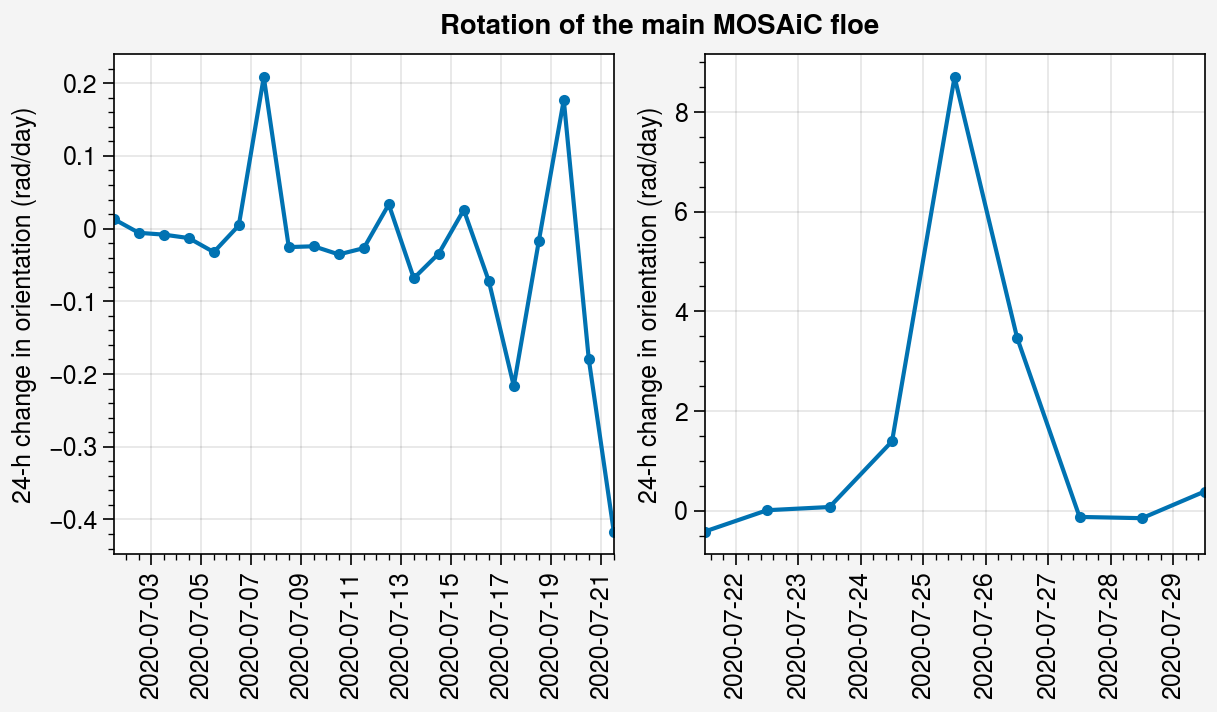

In [156]:
fig, ax = pplt.subplots(ncols=2, share=False)
ax[0].plot(daily_change[slice('2020-07-01', '2020-07-21')], marker='.')
ax[1].plot(daily_change[slice('2020-07-21', '2020-07-31')], marker='.')
ax.format(xlabel='', ylabel='24-h change in orientation (rad/day)')
ax.format(suptitle='Rotation of the main MOSAiC floe')
fig.save('../figures/figS5_mosaic_daily_rotation.png', dpi=300)

In [135]:
daily_change[daily_change < 0]

time
2020-07-02 12:00:00   -0.000920
2020-07-03 12:00:00   -0.001314
2020-07-04 12:00:00   -0.002068
2020-07-05 12:00:00   -0.005146
2020-07-08 12:00:00   -0.004046
2020-07-09 12:00:00   -0.003868
2020-07-10 12:00:00   -0.005651
2020-07-11 12:00:00   -0.004275
2020-07-13 12:00:00   -0.010867
2020-07-14 12:00:00   -0.005457
2020-07-16 12:00:00   -0.011437
2020-07-17 12:00:00   -0.034452
2020-07-18 12:00:00   -0.002777
2020-07-20 12:00:00   -0.028579
2020-07-21 12:00:00   -0.066321
2020-07-27 12:00:00   -0.019485
2020-07-28 12:00:00   -0.023451
Name: tower_heading, dtype: float64